<a href="https://colab.research.google.com/github/EsserMishelle/customer-spending-segmentation/blob/main/1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Spending Segmentation


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

np.random.seed(42)

In [ ]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/sik-flow/new_data1/refs/heads/main/Wholesale%20customers%20data.csv')
df_raw = df.copy() # for reference
df.head(10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


This analysis uses the **Wholesale Customers Data Set** from the UCI Machine Learning Repository. The dataset contains aggregated customer spending across multiple product categories, along with categorical variables describing customer type and geographic region.

## Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


According to the original documentation, this dataset has the following variables:

**Categorical Features:**
* Channel: Customer type (1 = Horeca, 2 = Retail)
* Region: Geographic region (1 = Lisbon, 2 = Oporto, 3 = Other)

**Numeric Labels (Behavioral Features):**
* Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen:
Annual spending amounts per product category

In [ ]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


**Observations (based on info() and describe()):**
* There are 440 rows and 8 variables, with no missing values.
* The spending variables show large ranges and high standard deviations, suggesting substantial differences in purchasing behavior.
* Median values are lower than mean or maximum values, implying the presence of high-spending customers.

## Distribution of Spending Variables

### Histograms(raw) and Log1p histograms

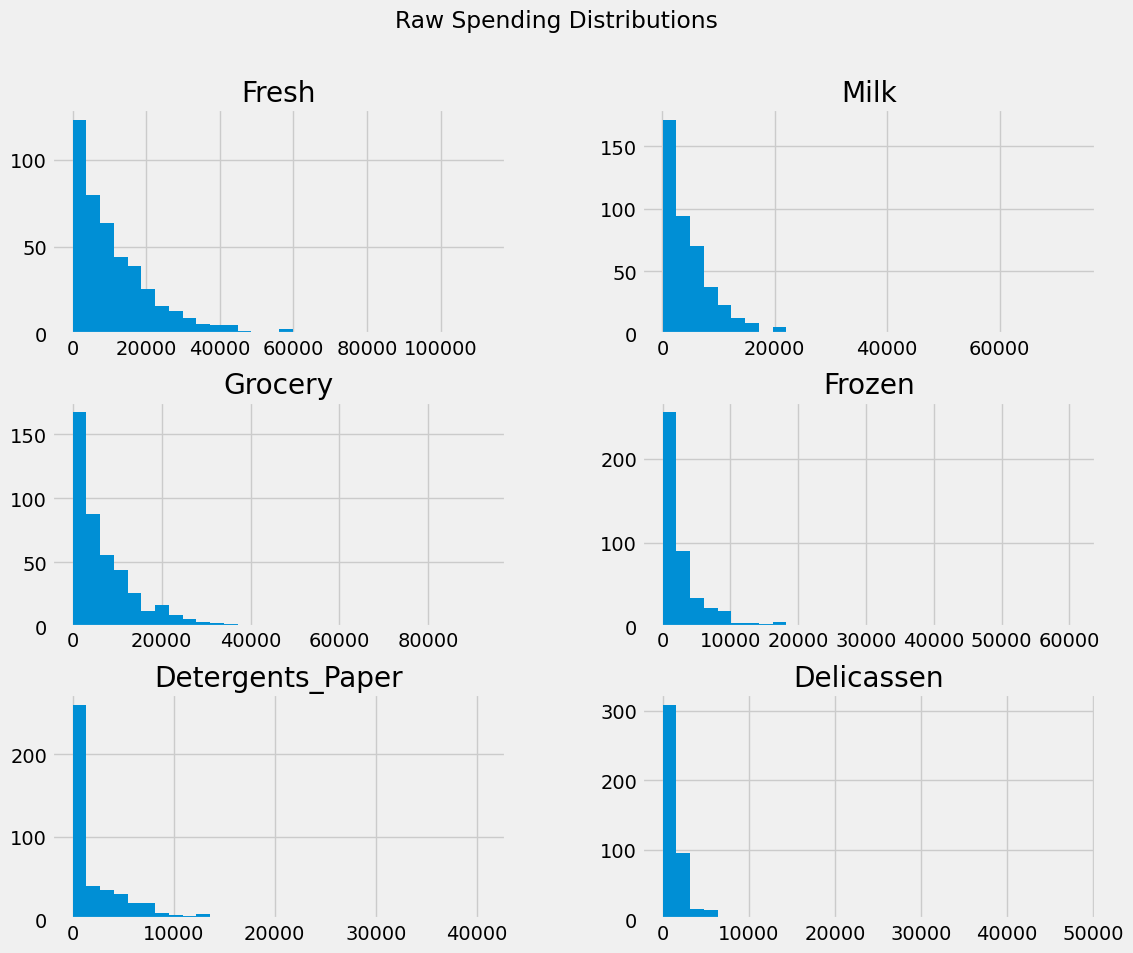

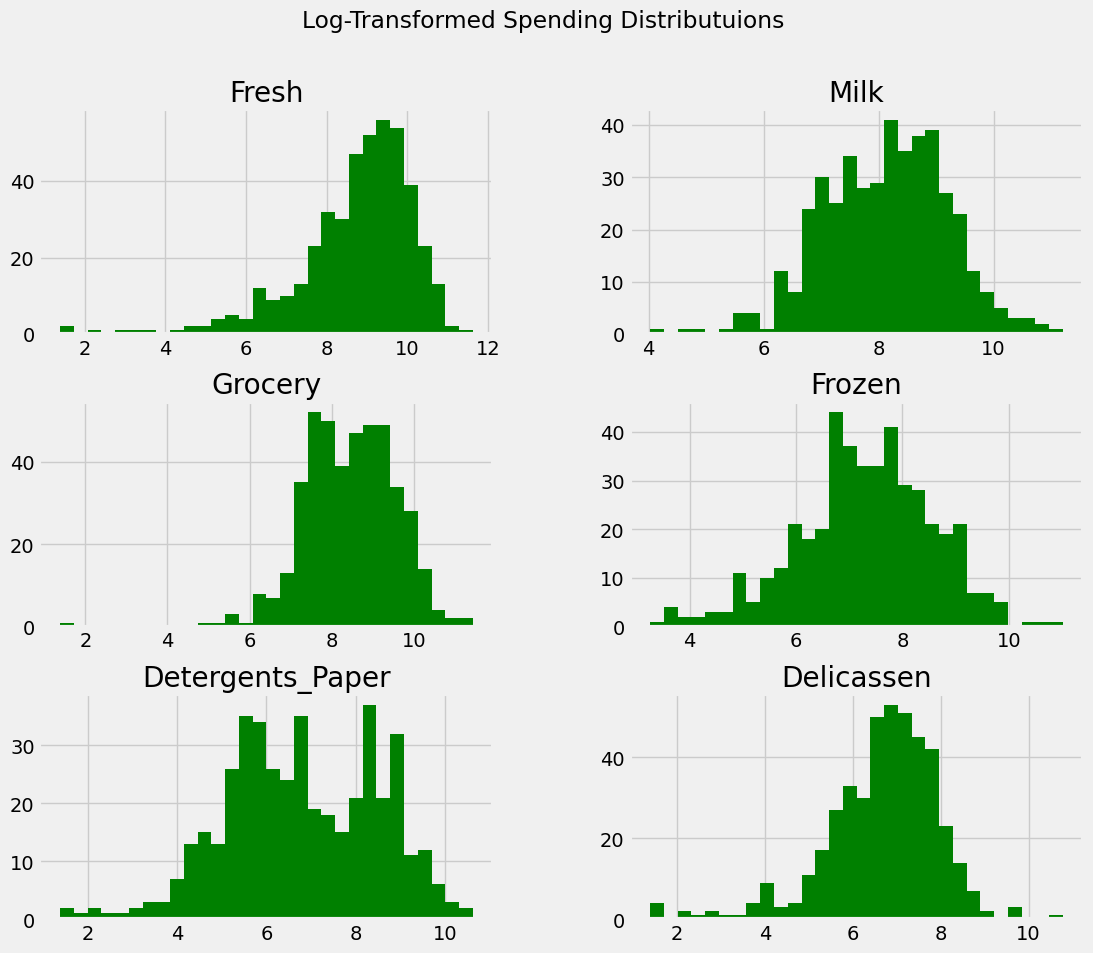

In [ ]:
# from sklearn
# Behavioral Features
spend_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen' ]

# Original scale (EDA)
df[spend_cols].hist(bins=30, figsize=(12, 10))
df[spend_cols].skew()
plt.suptitle('Raw Spending Distributions')
plt.show()

# After log transform
np.log1p(df[spend_cols]).hist(bins=30, figsize=(12, 10), color='Green')
plt.suptitle('Log-Transformed Spending Distributuions')
plt.show()


In [ ]:
from scipy.stats import skew, kurtosis

skew_before = df[spend_cols].apply(skew)
kurt_before = df[spend_cols].apply(kurtosis)

skew_after = np.log1p(df[spend_cols]).apply(skew)
kurt_after = np.log1p(df[spend_cols]).apply(kurtosis)

pd.DataFrame({
    'skew_before': skew_before,
    'skew_after': skew_after,
    'kurtosis_before': kurt_before,
    'kurtosis_after': kurt_after
})


,skew_before,skew_after,kurtosis_before,kurtosis_after
Fresh,2.552583,-1.569951,11.392124,3.993318
Milk,4.039922,-0.223299,24.376349,0.194848
Grocery,3.575187,-0.672635,20.664153,3.112444
Frozen,5.887826,-0.351451,54.056180,0.252882
Detergents_Paper,3.619458,-0.235155,18.780528,-0.311277
Delicassen,11.113534,-1.088101,168.747781,2.704041


The raw spending distributions show a strong right skew, with only a small number of customers attributing for disproportionately high expenditures. After applying the log1p transformation, both skewness and kurtosis are reduced across all spending variables before clustering.

## Outliers and Variablility
### Boxplots of Spending Features

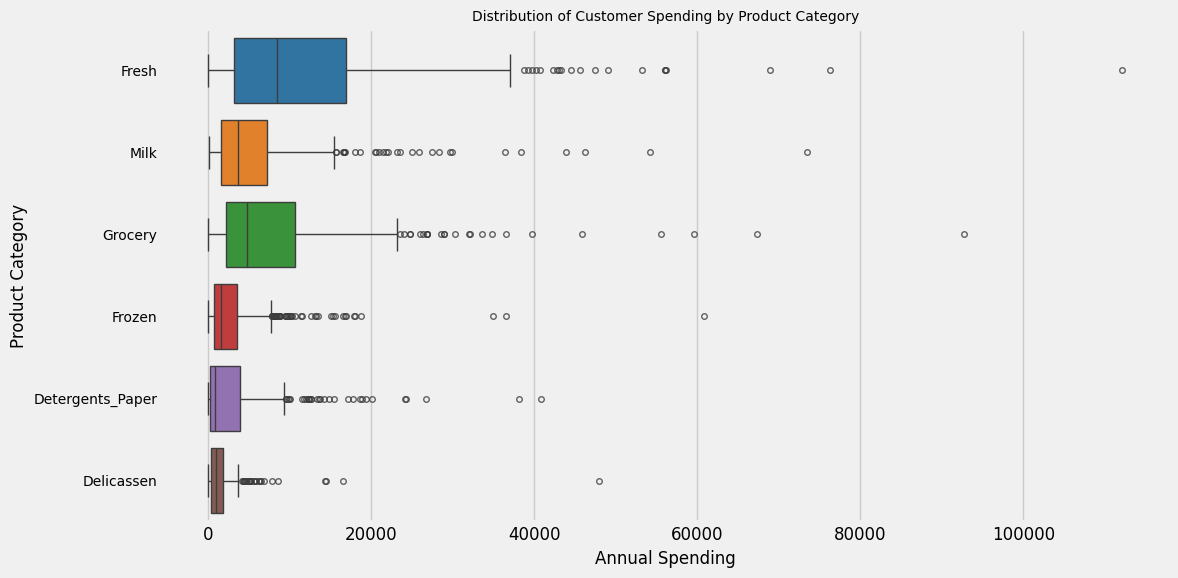

In [ ]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df[spend_cols],
    orient="h",
    palette="tab10",
    showfliers=True,
    flierprops=dict(marker='o', markersize=4, alpha=0.8)
)

plt.title("Distribution of Customer Spending by Product Category", fontsize=10)
plt.xlabel("Annual Spending", fontsize=12)
plt.ylabel("Product Category", fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()


Spending in the Fresh and Grocery categories show both higher median spending and wider ranges compared to other product categories, along with more extreme outliers.

## Correlation Analysis

* Channel and Region are categorical variables whose numeric encodings are not suitable for correlation or distance-based clustering.
* Rather than treating them as explanatory varibles, they are retained for post-cluster interpretation to contextualize behavior-based segments.

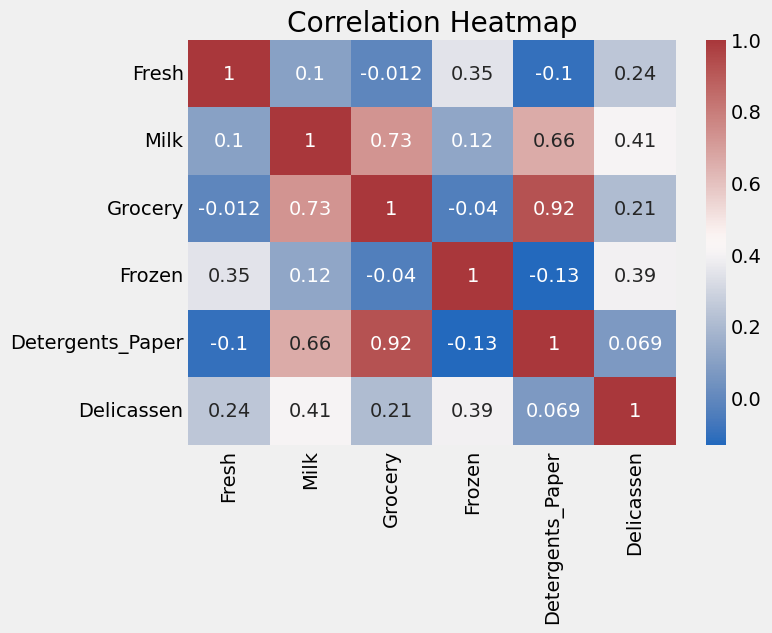

In [ ]:
# df[spend_cols].corr()
plt.figure(figsize=(7, 5))
sns.heatmap(df[spend_cols].corr(), annot=True, cmap='vlag' )
plt.title('Correlation Heatmap')
plt.show()

* Grocery and Detergents_Paper spending show a very strong positive correlation, implying similar purchasing behavior.
* Milk spending is also strongly correlated with Grocery, indicating related buying patterns.
* Grocery shows weak correlation with Fresh and Frozen, suggesting more independent purchasing behavior across these categories.

Text(0.5, 1.0, 'Grocery vs Detergents_Paper Spending')

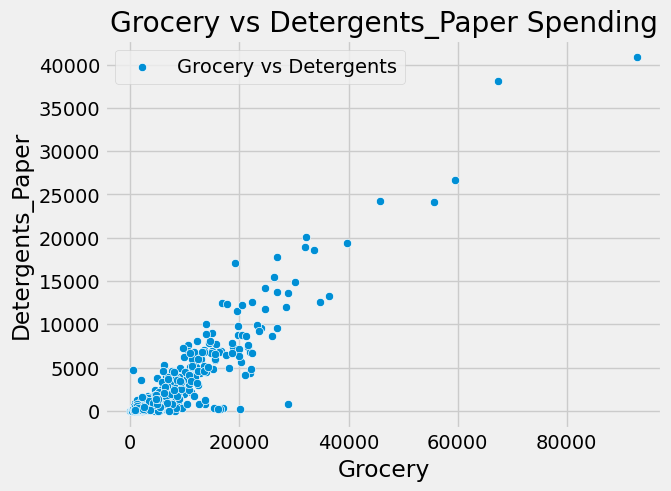

In [ ]:
sns.scatterplot(x='Grocery', y='Detergents_Paper', data=df, label='Grocery vs Detergents')
plt.title('Grocery vs Detergents_Paper Spending')

The scatter plot reinforces the strong positive relationship between Grocery and Detergents_Paper observed in the correlation analysis.

## Categorical Variable Overview
### Categorical variables are examined separately from numeric spending features to provide contextual information for post-cluster interpretation.

In [ ]:
df['Channel'].value_counts(normalize = True)

,proportion
Channel,
1,0.677273
2,0.322727


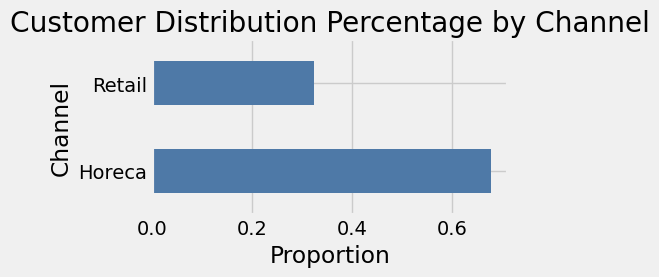

In [ ]:
plt.figure(figsize=(5, 3))
df['Channel'].value_counts(normalize=True).sort_index().plot(
    kind='barh',
    color="#4E79A7"
    )
plt.title("Customer Distribution Percentage by Channel")
plt.xlabel("Proportion")
plt.yticks([1, 0], ['Retail','Horeca'])
plt.tight_layout()
plt.show()

Horeca customers represent the majority of observations, while Retail customers account for a smaller proportion of the dataset.

In [ ]:
df['Region'].value_counts(normalize=True)

,proportion
Region,
3,0.718182
1,0.175000
2,0.106818


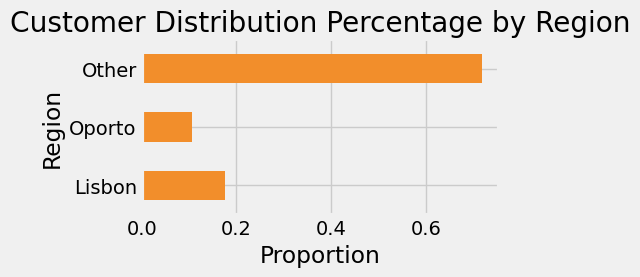

In [ ]:
plt.figure(figsize=(5, 3))
df['Region'].value_counts(normalize=True).sort_index().plot(
    kind='barh',
    color="#F28E2B"
)
plt.title("Customer Distribution Percentage by Region")
plt.xlabel("Proportion")
plt.yticks([0, 1, 2], ['Lisbon', 'Oporto', 'Other'])
plt.tight_layout()
plt.show()


Customers are primarily concentrated in the “Other” region, with Lisbon and Oporto each representing smaller shares of the overall dataset.